<a href="https://colab.research.google.com/github/Virppsa/AI-neural-networks/blob/main/Kursinis(AI_collapse).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#DI modelių kolapso tematika paruoštas tyriamasis darbas.
Tikslas - vizualiai atpažinti neuroninio tinklo VAE kolapsą naudojant MNIST duomenis.

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

from scipy.stats import norm

import keras
from keras.datasets import mnist
from keras.layers import Input, Reshape, Conv2D, Conv2DTranspose, Flatten, Dense, Lambda
from keras.models import Model
from keras import metrics
from keras import backend as K   # 'generic' backend so code works with either tensorflow or theano

K.clear_session()
np.random.seed(237)

In [5]:
from google.colab import drive

In [8]:
from keras.datasets import mnist

In [6]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [9]:
# Load Dataset
(X_train, Y_train), (X_valid, Y_valid) = mnist.load_data()

In [13]:
num_labels = len(np.unique(Y_train))
num_labels

10

In [16]:
# Normalize and reshape
X_train = X_train.astype('float32') / 255.
X_train = X_train.reshape(-1,28,28,1)

X_valid = X_valid.astype('float32') / 255.
X_valid = X_valid.reshape(-1,28,28,1)

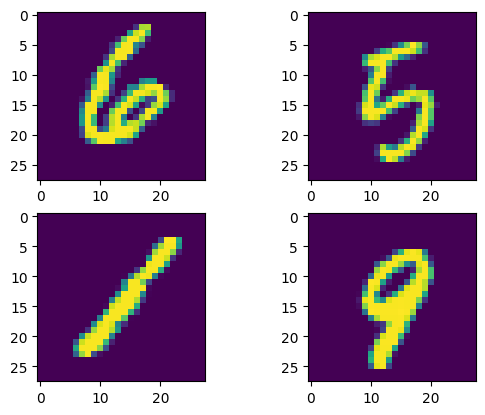

In [17]:
plt.figure(1)
plt.subplot(221)
plt.imshow(X_train[13][:,:,0])

plt.subplot(222)
plt.imshow(X_train[690][:,:,0])

plt.subplot(223)
plt.imshow(X_train[2375][:,:,0])

plt.subplot(224)
plt.imshow(X_train[42013][:,:,0])
plt.show()


In [30]:
#Model construction:--------------------------------------------------------

# img_shape = (28, 28, 1)    # for MNIST
# batch_size = 16
# latent_dim = 2  # Number of latent dimension parameters

# # Encoder architecture: Input -> Conv2D*4 -> Flatten -> Dense
# input_img = Input(shape=img_shape)

# x = Conv2D(32, 3, padding='same', activation='relu')(input_img)
# x = Conv2D(64, 3, padding='same', activation='relu', strides=(2, 2))(x)
# x = Conv2D(64, 3, padding='same', activation='relu')(x)
# x = Conv2D(64, 3, padding='same', activation='relu')(x)

# # need to know the shape of the network here for the decoder
# shape_before_flattening = K.int_shape(x)

# x = Flatten()(x)
# x = Dense(32, activation='relu')(x)

# # Two outputs, latent mean and (log)variance
# z_mu = Dense(latent_dim)(x)
# z_log_sigma = Dense(latent_dim)(x)




import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense
from tensorflow.keras.models import Model

# Model construction:--------------------------------------------------------
img_shape = (28, 28, 1)    # for MNIST
#batch_size = 16
batch_size = 256
latent_dim = 2  # Number of latent dimension parameters

# Encoder architecture: Input -> Conv2D*4 -> Flatten -> Dense
input_img = Input(shape=img_shape)

x = Conv2D(32, 3, padding='same', activation='relu')(input_img)
x = Conv2D(64, 3, padding='same', activation='relu', strides=(2, 2))(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)

# Capture shape before flattening
shape_before_flattening = x.shape  # Use .shape instead of K.int_shape

x = Flatten()(x)
x = Dense(32, activation='relu')(x)

# Two outputs, latent mean and (log)variance
z_mu = Dense(latent_dim)(x)
z_log_sigma = Dense(latent_dim)(x)

# Print the captured shape
print("Shape before flattening:", shape_before_flattening)


Shape before flattening: (None, 14, 14, 64)


In [31]:
# # sampling function
# def sampling(args):
#     z_mu, z_log_sigma = args
#     epsilon = K.random_normal(shape=(K.shape(z_mu)[0], latent_dim),
#                               mean=0., stddev=1.)
#     return z_mu + K.exp(z_log_sigma) * epsilon

# # sample vector from the latent distribution
# z = Lambda(sampling)([z_mu, z_log_sigma])



from tensorflow.keras.layers import Lambda
import tensorflow.keras.backend as K

# Sampling function
def sampling(args):
    z_mu, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mu)[0], latent_dim),
                              mean=0., stddev=1.0)
    return z_mu + K.exp(0.5 * z_log_sigma) * epsilon  # Use 0.5 to scale log_sigma correctly

# Explicitly define the output shape
def sampling_output_shape(input_shape):
    return input_shape[0]  # The output shape is the same as z_mu's shape

# Sample vector from the latent distribution
z = Lambda(sampling, output_shape=sampling_output_shape)([z_mu, z_log_sigma])


In [32]:
# # decoder takes the latent distribution sample as input
# decoder_input = Input(K.int_shape(z)[1:])

# # Expand to 784 total pixels
# x = Dense(np.prod(shape_before_flattening[1:]), activation='relu')(decoder_input)

# # reshape
# x = Reshape(shape_before_flattening[1:])(x)

# # use Conv2DTranspose to reverse the conv layers from the encoder
# x = Conv2DTranspose(32, 3, padding='same', activation='relu', strides=(2, 2))(x)
# x = Conv2D(1, 3, padding='same', activation='sigmoid')(x)

# # decoder model statement
# decoder = Model(decoder_input, x)

# # apply the decoder to the sample from the latent distribution
# z_decoded = decoder(z)


from tensorflow.keras.layers import Dense, Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
import numpy as np

# Decoder takes the latent distribution sample as input
decoder_input = Input(shape=(latent_dim,))
x = Dense(np.prod(shape_before_flattening[1:]), activation='relu')(decoder_input)
x = Reshape(shape_before_flattening[1:])(x)

# Reverse the Conv layers from the encoder
x = Conv2DTranspose(64, 3, padding='same', activation='relu', strides=(2, 2))(x)
x = Conv2DTranspose(32, 3, padding='same', activation='relu')(x)
x = Conv2D(1, 3, padding='same', activation='sigmoid')(x)

# Decoder model
decoder = Model(decoder_input, x, name="decoder")

# Apply decoder to the sampled latent variable
z_decoded = decoder(z)


In [33]:
# from tensorflow.keras.layers import Layer
# from tensorflow.keras.losses import binary_crossentropy

# class CustomVariationalLayer(Layer):
#     def call(self, inputs):
#         x, z_decoded = inputs
#         # Flatten for reconstruction loss
#         x_flat = tf.reshape(x, shape=(-1, np.prod(img_shape)))
#         z_decoded_flat = tf.reshape(z_decoded, shape=(-1, np.prod(img_shape)))

#         # Reconstruction loss
#         reconstruction_loss = tf.reduce_mean(
#             tf.reduce_sum(binary_crossentropy(x_flat, z_decoded_flat), axis=-1)
#         )

#         # KL Divergence loss
#         kl_loss = -0.5 * tf.reduce_mean(
#             1 + z_log_sigma - tf.square(z_mu) - tf.exp(z_log_sigma)
#         )

#         # Add losses
#         self.add_loss(reconstruction_loss + kl_loss)
#         return x  # Pass the input forward



class CustomVariationalLayer(Layer):
    def call(self, inputs):
        x, z_decoded, z_mu, z_log_sigma = inputs
        # Flatten for reconstruction loss
        x_flat = tf.reshape(x, shape=(-1, np.prod(img_shape)))
        z_decoded_flat = tf.reshape(z_decoded, shape=(-1, np.prod(img_shape)))

        # Reconstruction loss
        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(binary_crossentropy(x_flat, z_decoded_flat), axis=-1)
        )

        # KL Divergence loss
        kl_loss = -0.5 * tf.reduce_mean(
            1 + z_log_sigma - tf.square(z_mu) - tf.exp(z_log_sigma)
        )

        # Add losses
        self.add_loss(reconstruction_loss + kl_loss)
        return x  # Pass the input forward


In [34]:
# Apply the custom loss layer
y = CustomVariationalLayer()([input_img, z_decoded, z_mu, z_log_sigma])

In [35]:
vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 28, 28, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 28, 28, 32)     │            320 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_11 (Conv2D)        │ (None, 14, 14, 64)     │         18,496 │ conv2d_10[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 14, 14, 64)     │         36,928 │ conv2d_11[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_13 (Conv2D)        │ (None, 14, 14, 64)     │         36,928 │ conv2d_12[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 12544)          │              0 │ conv2d_13[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 32)             │        401,440 │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 2)              │             66 │ dense_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 2)              │             66 │ dense_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_2 (Lambda)         │ (None, 2)              │              0 │ dense_6[0][0],         │
│                           │                        │                │ dense_7[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder (Functional)      │ (None, 28, 28, 1)      │         93,313 │ lambda_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ custom_variational_layer… │ (None, 28, 28, 1)      │              0 │ input_layer_4[0][0],   │
│ (CustomVariationalLayer)  │                        │                │ decoder[0][0],         │
│                           │                        │                │ dense_6[0][0],         │
│                           │                        │                │ dense_7[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 587,557 (2.24 MB)

 Trainable params: 587,557 (2.24 MB)

 Non-trainable params: 0 (0.00 B)

#Treniravimas

Training Generation 1...
Epoch 1/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 24s 55ms/step - loss: 87109736.0000 - val_loss: 62.7526
Epoch 2/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - loss: 61.2090 - val_loss: 57.3198
Epoch 3/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 57.8205 - val_loss: 56.1192
Epoch 4/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - loss: 56.2716 - val_loss: 54.8477
Epoch 5/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - loss: 55.1852 - val_loss: 54.0357
Epoch 6/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - loss: 54.1968 - val_loss: 53.0067
Epoch 7/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - loss: 53.6405 - val_loss: 52.2927
Epoch 8/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - loss: 53.0388 - val_loss: 51.9343
Epoch 9/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - loss: 52.5539 - val_loss: 51.5465
Epoch 10/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - loss: 52.0234 - val_loss: 51.1775
Epoch 11/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - loss: 51.7456 - 

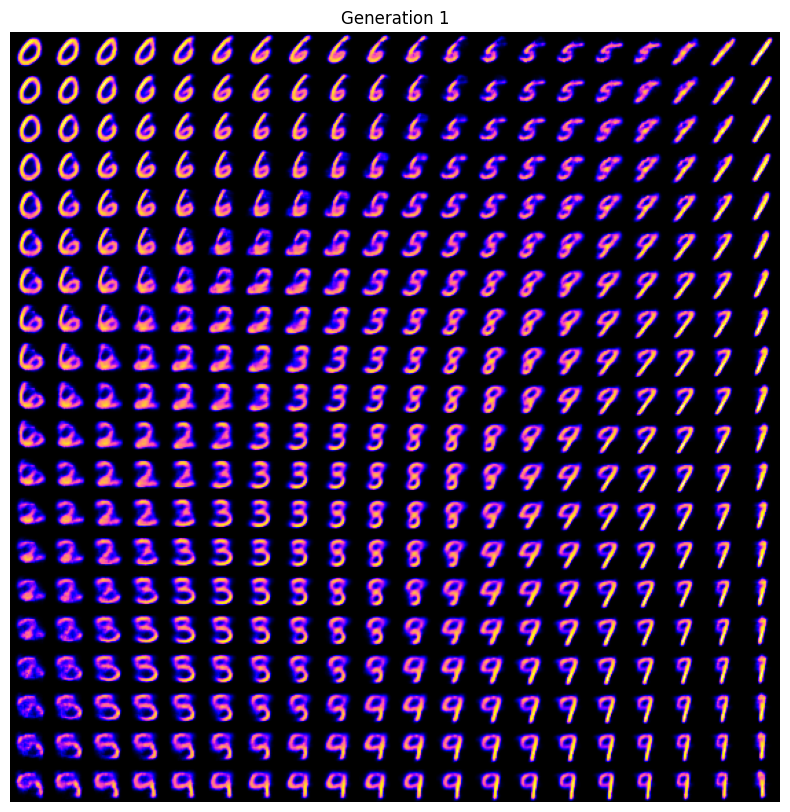

Training Generation 2...
Epoch 1/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - loss: 49.6171 - val_loss: 49.2944
Epoch 2/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - loss: 49.4494 - val_loss: 49.4243
Epoch 3/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - loss: 49.3386 - val_loss: 49.1753
Epoch 4/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 49.0660 - val_loss: 49.1309
Epoch 5/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - loss: 49.1362 - val_loss: 49.0129
Epoch 6/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - loss: 48.8424 - val_loss: 48.9784
Epoch 7/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - loss: 48.7885 - val_loss: 48.9571
Epoch 8/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - loss: 48.7664 - val_loss: 48.8703
Epoch 9/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - loss: 48.6814 - val_loss: 48.8275
Epoch 10/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - loss: 48.5911 - val_loss: 48.7113
Epoch 11/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - loss: 48.4985 - val_los

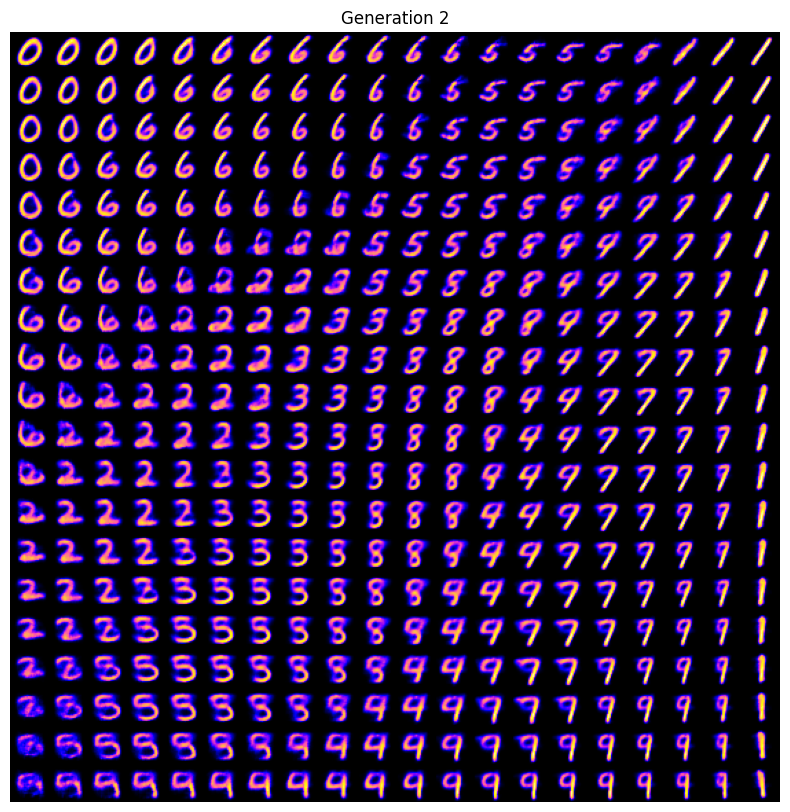

Training Generation 3...
Epoch 1/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - loss: 47.8890 - val_loss: 48.3627
Epoch 2/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 47.7223 - val_loss: 48.4393
Epoch 3/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - loss: 47.6913 - val_loss: 48.3994
Epoch 4/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - loss: 47.8044 - val_loss: 48.3360
Epoch 5/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - loss: 47.5677 - val_loss: 48.3323
Epoch 6/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - loss: 47.6164 - val_loss: 48.2330
Epoch 7/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - loss: 47.6992 - val_loss: 48.3423
Epoch 8/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - loss: 47.4636 - val_loss: 48.2824
Epoch 9/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - loss: 47.4981 - val_loss: 48.3446
Epoch 10/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - loss: 47.5375 - val_loss: 48.2700
Epoch 11/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 47.4055 - val_l

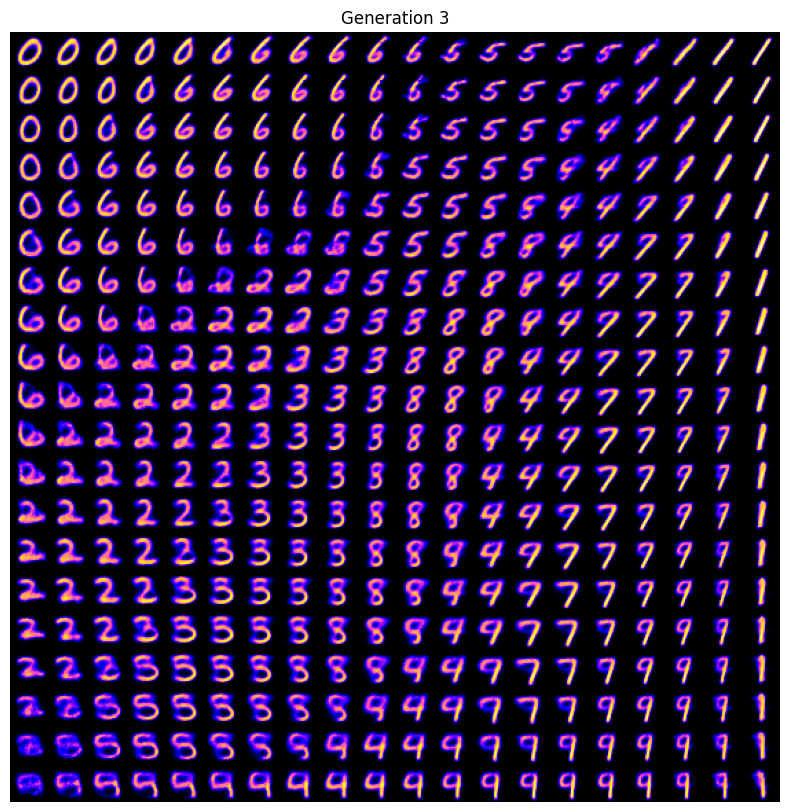

Training Generation 4...
Epoch 1/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - loss: 47.0531 - val_loss: 48.1770
Epoch 2/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - loss: 46.9970 - val_loss: 48.2661
Epoch 3/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 47.0017 - val_loss: 48.0947
Epoch 4/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 46.9631 - val_loss: 48.2044
Epoch 5/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 46.9984 - val_loss: 48.1249
Epoch 6/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - loss: 46.9420 - val_loss: 48.0761
Epoch 7/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - loss: 46.9100 - val_loss: 48.1431
Epoch 8/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - loss: 46.8725 - val_loss: 48.1267
Epoch 9/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - loss: 46.9014 - val_loss: 48.0537
Epoch 10/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 46.9134 - val_loss: 48.0812
Epoch 11/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 46.7499 - val_loss:

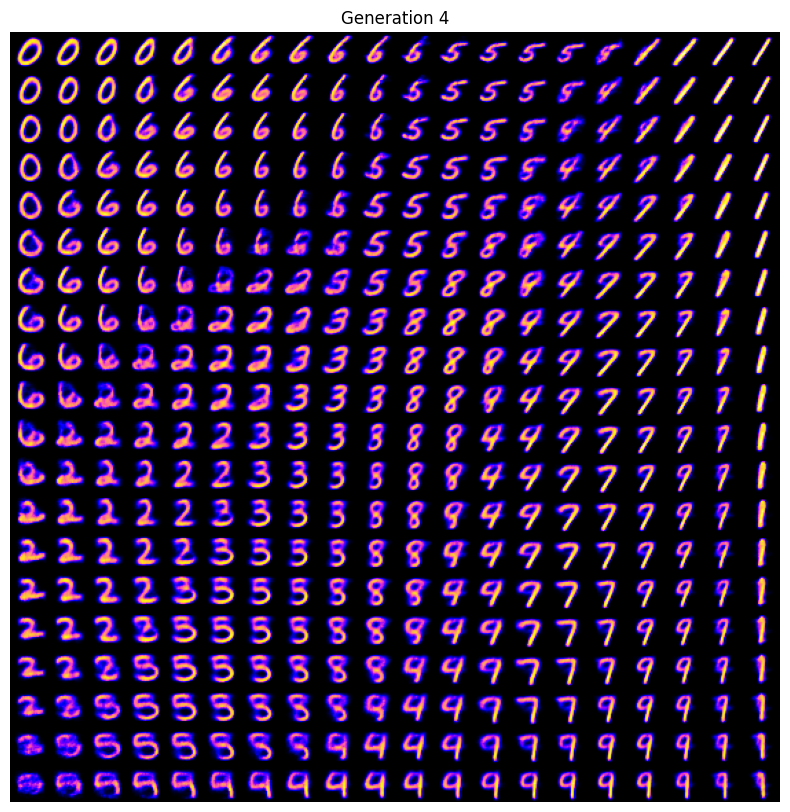

Training Generation 5...
Epoch 1/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 46.7014 - val_loss: 48.1409
Epoch 2/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - loss: 46.6660 - val_loss: 48.1034
Epoch 3/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - loss: 46.6760 - val_loss: 48.2124
Epoch 4/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - loss: 46.5640 - val_loss: 48.1795
Epoch 5/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - loss: 46.5110 - val_loss: 48.1042
Epoch 6/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - loss: 46.5256 - val_loss: 48.1529
Epoch 7/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - loss: 46.5736 - val_loss: 48.1856
Epoch 8/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - loss: 46.3983 - val_loss: 48.1688
Epoch 9/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 46.4871 - val_loss: 48.0979
Epoch 10/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 46.5007 - val_loss: 48.2518
Epoch 11/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 46.4636 - val_lo

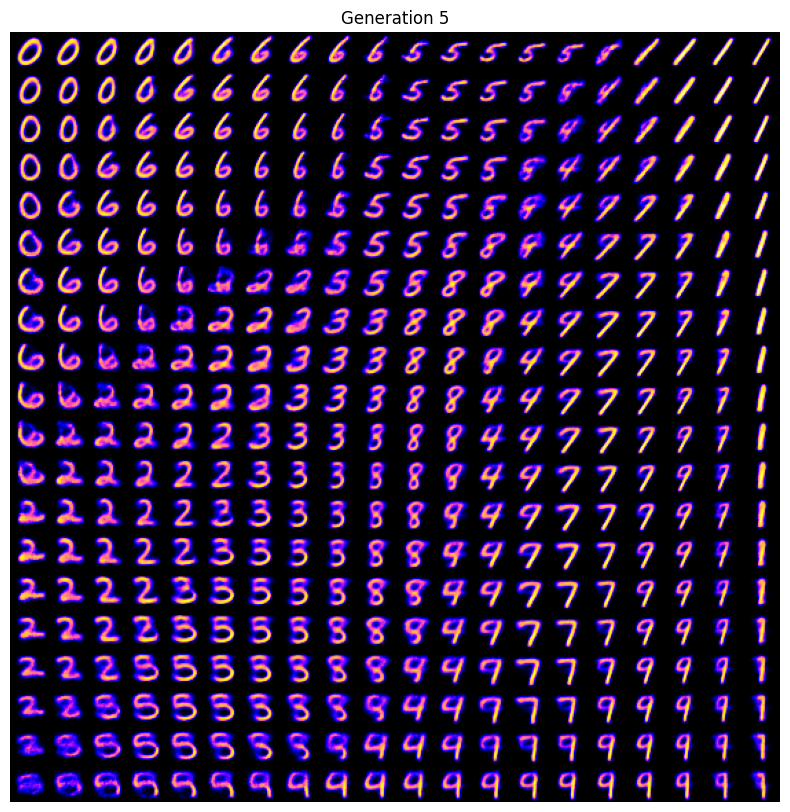

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Parameters
num_epochs = 20
num_generations = 5
batch_size = 256
latent_dim = 2
digit_size = 28
n = 20  # Grid size for visualization (20x20 digits)

# Train model for multiple generations
for generation in range(num_generations):
    print(f"Training Generation {generation + 1}...")

    # Train the model
    vae.fit(x=X_train, y=None, shuffle=True, epochs=num_epochs, batch_size=batch_size, validation_data=(X_valid, None))

    # Display a 2D manifold of the digits
    figure = np.zeros((digit_size * n, digit_size * n))

    # Construct grid of latent variable values
    grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
    grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

    # Decode for each square in the grid
    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            Z_sample = np.array([[xi, yi]])
            Z_sample = np.tile(Z_sample, batch_size).reshape(batch_size, 2)
            X_decoded = decoder.predict(Z_sample, batch_size=batch_size)
            digit = X_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    # Display the generated figure for the current generation
    plt.figure(figsize=(10, 10))
    plt.imshow(figure, cmap='gnuplot2')
    plt.title(f"Generation {generation + 1}")
    plt.axis("off")
    plt.show()


#Dataset with real data and generated data

Training Generation 1...
Epoch 1/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 46.2612
Epoch 2/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 46.2920
Epoch 3/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 46.2771
Epoch 4/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - loss: 46.2046
Epoch 5/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - loss: 46.2856
Epoch 6/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - loss: 46.2605
Epoch 7/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 46.2049
Epoch 8/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - loss: 46.1218
Epoch 9/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 46.1219
Epoch 10/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 46.2151
Epoch 11/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 46.1872
Epoch 12/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 46.0828
Epoch 13/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 46.1845
Epoch 14/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 46.150

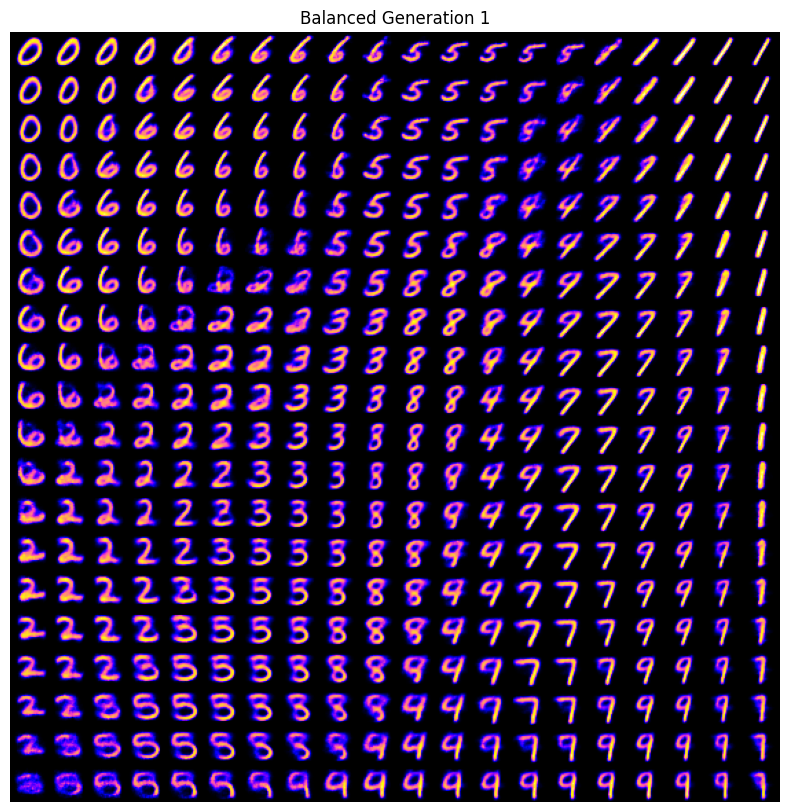

Training Generation 2...
Epoch 1/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 47.0746
Epoch 2/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 46.8989
Epoch 3/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 46.8510
Epoch 4/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 46.7511
Epoch 5/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 46.6572
Epoch 6/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 46.9204
Epoch 7/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 46.7583
Epoch 8/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 46.7946
Epoch 9/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 46.6488
Epoch 10/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 46.7337
Epoch 11/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 46.7325
Epoch 12/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 46.7058
Epoch 13/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 46.6163
Epoch 14/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 46.6632

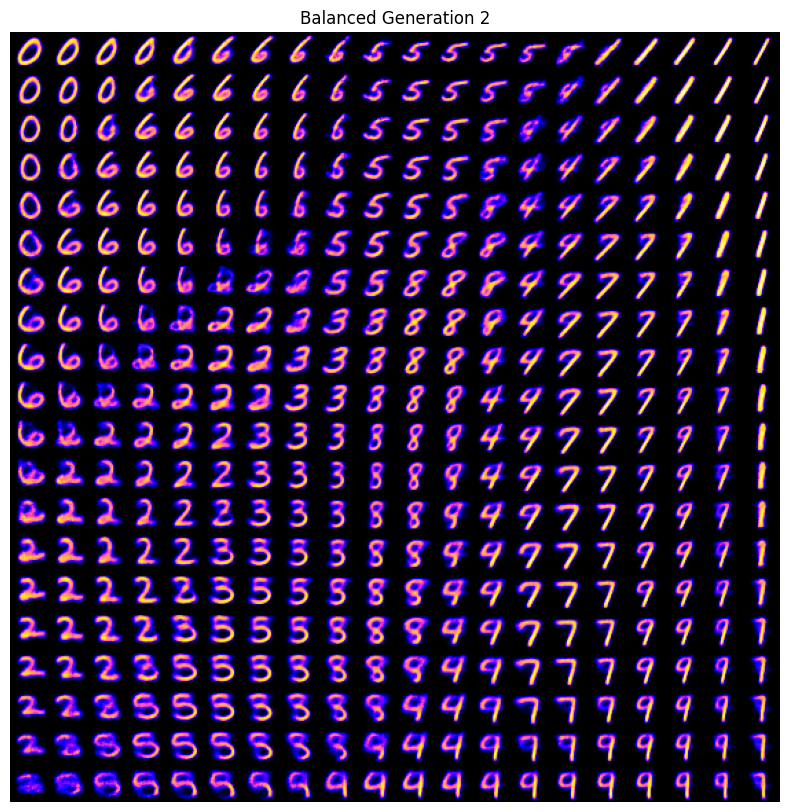

Training Generation 3...
Epoch 1/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 46.5702
Epoch 2/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 46.5316
Epoch 3/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 46.5989
Epoch 4/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 46.5433
Epoch 5/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 46.5627
Epoch 6/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 46.5051
Epoch 7/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 46.4258
Epoch 8/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 46.3666
Epoch 9/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 46.4403
Epoch 10/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 46.4420
Epoch 11/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 46.3813
Epoch 12/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 46.4156
Epoch 13/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 46.3646
Epoch 14/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 46.3917


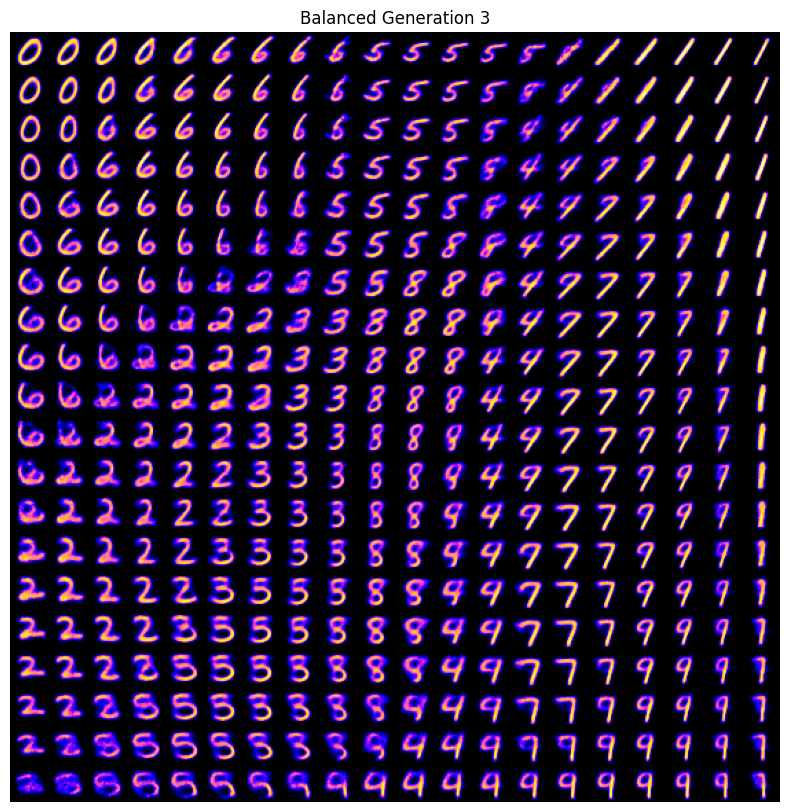

Training Generation 4...
Epoch 1/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 46.3703
Epoch 2/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 46.3771
Epoch 3/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 46.4452
Epoch 4/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - loss: 46.2818
Epoch 5/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 46.2956
Epoch 6/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - loss: 46.3192
Epoch 7/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 46.3010
Epoch 8/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - loss: 46.2592
Epoch 9/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 46.3381
Epoch 10/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 46.3138
Epoch 11/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 46.2719
Epoch 12/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 46.1757
Epoch 13/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 46.2261
Epoch 14/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 46.1804


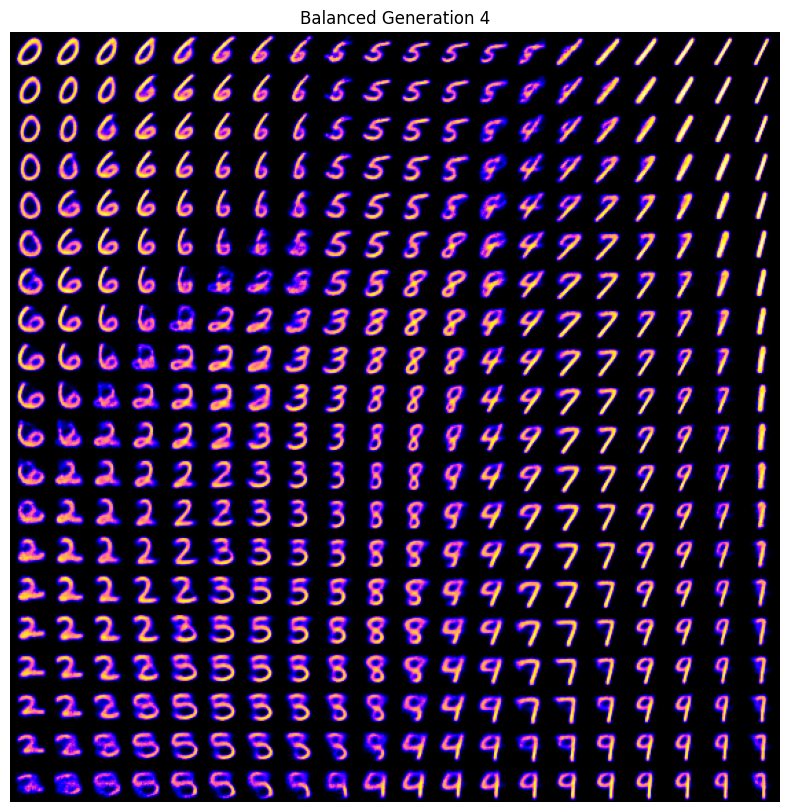

Training Generation 5...
Epoch 1/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 46.2379
Epoch 2/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 46.3345
Epoch 3/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - loss: 46.2199
Epoch 4/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 46.2510
Epoch 5/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - loss: 46.2576
Epoch 6/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 46.2771
Epoch 7/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 46.1809
Epoch 8/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 46.2074
Epoch 9/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - loss: 46.2179
Epoch 10/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 46.0703
Epoch 11/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 46.2367
Epoch 12/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 46.0804
Epoch 13/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 46.0151
Epoch 14/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 46.07

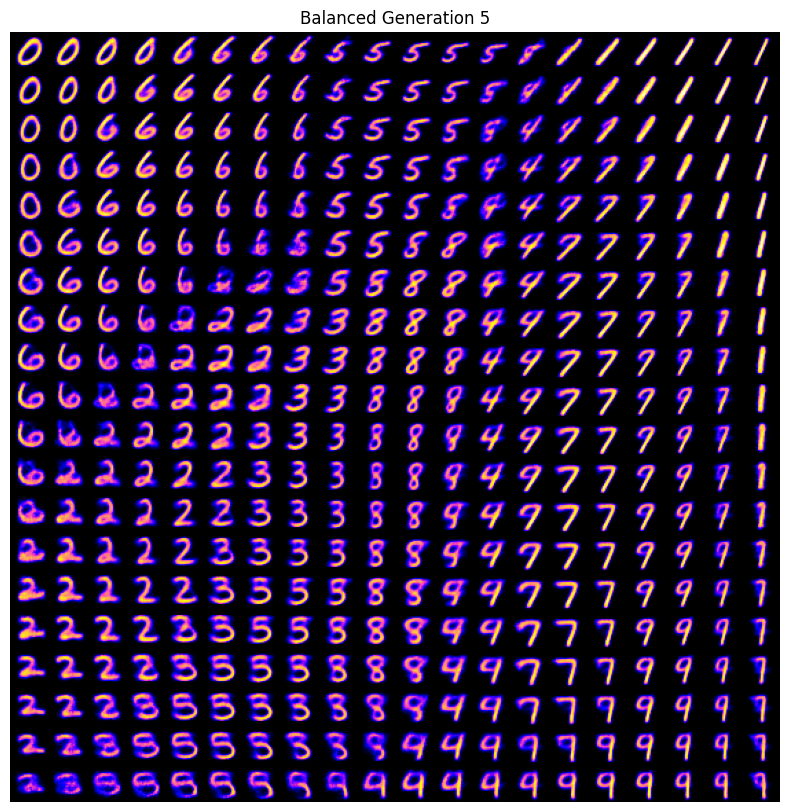

In [38]:
# Parameters
real_ratio = 0.75  # 75% real data
generated_ratio = 0.25  # 25% generated data
total_size = 60000  # Fixed total dataset size per generation
latent_dim = 2
batch_size = 256
num_epochs = 20  # Train for 20 epochs per generation
num_generations = 5  # Number of generations
digit_size = 28
n = 20  # Grid size for visualization (20x20 digits)

# Function to balance training data
def balance_training_set(real_data, generated_data, total_size, real_ratio, generated_ratio):
    n_real = int(total_size * real_ratio)
    n_generated = total_size - n_real  # Remaining for generated data

    # Sample real data
    real_indices = np.random.choice(real_data.shape[0], n_real, replace=False)
    real_subset = real_data[real_indices]

    # Sample generated data
    generated_subset = generated_data[:n_generated]

    # Combine real and generated data
    balanced_data = np.concatenate([real_subset, generated_subset], axis=0)
    np.random.shuffle(balanced_data)  # Shuffle to mix real and generated data
    return balanced_data

# Function to generate synthetic images
def generate_images(decoder, n_samples, latent_dim):
    z_samples = np.random.normal(size=(n_samples, latent_dim))  # Sample from latent space
    generated_images = decoder.predict(z_samples, batch_size=batch_size)
    return generated_images

# Start with the original dataset
X_train_balanced = X_train.copy()

# Train for multiple generations
for generation in range(num_generations):
    print(f"Training Generation {generation + 1}...")

    # Train the VAE for 20 epochs
    vae.fit(x=X_train_balanced, y=None, shuffle=True, epochs=num_epochs, batch_size=batch_size)

    # Generate synthetic images
    n_generated = int(total_size * generated_ratio)
    generated_images = generate_images(decoder, n_generated, latent_dim)

    # Balance the dataset for the next generation
    X_train_balanced = balance_training_set(X_train, generated_images, total_size, real_ratio, generated_ratio)

    # Visualize a 2D manifold of the latent space
    figure = np.zeros((digit_size * n, digit_size * n))
    grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
    grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            Z_sample = np.array([[xi, yi]])
            Z_sample = np.tile(Z_sample, batch_size).reshape(batch_size, latent_dim)
            X_decoded = decoder.predict(Z_sample, batch_size=batch_size)
            digit = X_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    plt.imshow(figure, cmap='gnuplot2')
    plt.title(f"Balanced Generation {generation + 1}")
    plt.axis("off")
    plt.show()



NameError: name 'Model' is not defined